## Indoor Action Recognizer tutorial

In [1]:
# Import load_model from keras in tensorflow
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import json

#### We create a function to load a video file and preprocess it

In [2]:
import cv2
import numpy as np

def load_video(video_path, height=224, width=224, frames_wanted=64, step=64):
    video_reader = cv2.VideoCapture(video_path)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video stream or file")


    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    init_h, init_w, final_h, final_w = __get_window_coord(video_h, video_w, height, width, True)

    video1 = []
    current_frame = 0
    final_frame = n_frames

    while current_frame+frames_wanted <= final_frame:
        frames_recorded = 0
        window = []
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        while frames_recorded < frames_wanted:
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame[init_h:final_h,init_w:final_w],
                                        cv2.COLOR_BGR2RGB)
                window.append(frame_rgb)
                frames_recorded = frames_recorded + 1
            else:
                break
        video1.append(window)
        current_frame = current_frame + step

    del window
    cap.release()
    del cap

    video =  np.array(video1, dtype=np.float32)
    del video1

    
    # We normalize each video recorded
    video = __scale_video(video)

    return video

def __scale_video(x, type="-1_1"):
    x = x.astype(np.float32)
    if type == "-1_1":
        x /= 127.5
        x -=1.
    else:
        x /= 255.
    return x

def __get_window_coord(video_h, video_w, window_h, window_w,  test):
    if test:
        init_h = int(video_h/2 - window_h/2)
        init_w = int(video_w/2 - window_w/2)

    else:
        init_h = np.random.randint(0, video_h - window_h + 1)
        init_w = np.random.randint(0, video_w - window_w + 1)

    final_h = init_h+window_h
    final_w = init_w+window_w

    return init_h, init_w, final_h, final_w

In [3]:
def show_video(video):
    frames = 5
    i = 0
    fig, axs = plt.subplots(1, frames, figsize=(20,20))
    for k in np.linspace(0, 64, frames).astype(np.uint8):
        if k >= video.shape[0]:
            k = video.shape[0] - 1
        video_k = np.uint8(((video[k] + 1) * 127.5))
        axs[i].imshow(np.uint8(video_k))
        i += 1

## We create a function that runs the inference and outputs the recognized action

In [4]:
def predict_video(model, video, actions_list):
    prediction = model.predict(video, batch_size=8)
    prediction = prediction.mean(axis=0)
    detected_action = np.argmax(prediction, axis=-1)

    print("Action recognizer detected: {} - with a confidence of: {:0.2f}%".format(actions_list[str(detected_action)],
                                                                        prediction[detected_action]*100))

Load the the actions name and its ID

In [5]:
with open("actions_list.json", "r") as file:
    actions_list = json.loads(file.read())

Load the model with tensorflow. It is trained to receive 64 frames at a spatial resolution of 224x224 pixels

In [6]:
model = load_model("model/indoor_action_recognizer.hdf5")

Load the video that will be analyzed. Take into account that it returns a list of clips 64 frames of the whole video.

In [7]:
video_walking = load_video("videos/video_walking.mp4", height=224, width=224, frames_wanted=64)

Example of a video of a person walking

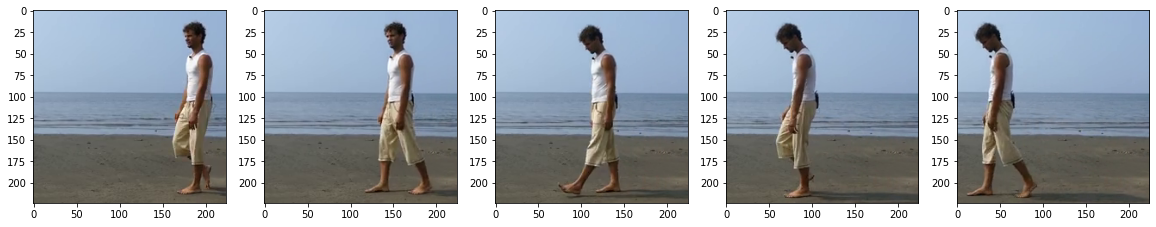

In [8]:
show_video(video_walking[1])

The model detects that a person is walking with a confidence of 87%

In [9]:
predict_video(model, video_walking, actions_list)

Action recognizer detected: walk - with a confidence of: 87.31%


Other example but with a person falling down

In [10]:
video_falling = load_video("videos/video_falling.mp4", height=224, width=224, frames_wanted=64)

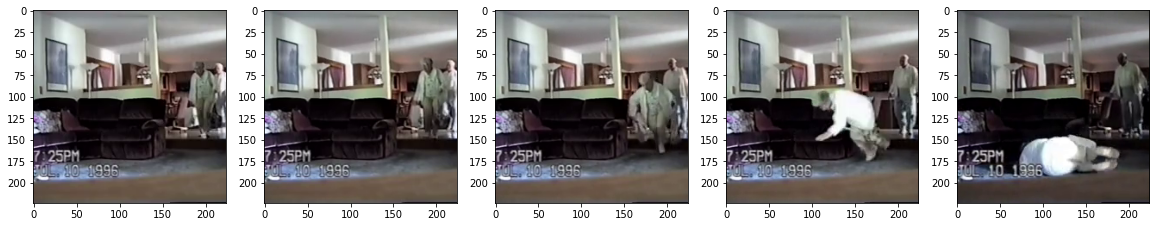

In [11]:
show_video(video_falling[0])

Prediction of the video

In [12]:
predict_video(model, video_falling, actions_list)

Action recognizer detected: fall - with a confidence of: 25.24%
